<a href="https://colab.research.google.com/github/hy2632/SystematicTrading/blob/main/Ketler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

In [ ]:
import backtrader as bt
import datetime
import talib

In [ ]:
"""
Ketler Channel
"""

class Ketler(bt.Indicator):
    params = dict(ema=20, atr=17)
    lines = ("expo", "atr", "upper", "lower")  # Define the four lines
    plotinfo = dict(subplot=False)
    plotlines = dict(
        upper=dict(ls='--'),
        lower=dict(_samecolor=True),
    )

    def __init__(self):
        self.l.expo = bt.talib.EMA(self.datas[0].close, timeperiod=self.params.ema)
        self.l.atr = bt.talib.ATR(self.data.high, self.data.low, self.data.close, timeperiod=self.params.atr)
        self.l.upper = self.l.expo + self.l.atr
        self.l.lower = self.l.expo - self.l.atr


class Strategy(bt.Strategy):
    ''' Logging function for strategy'''

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.ketler = Ketler()
        self.close = self.data.close

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted by broker, nothing to do
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED, Price: {order.executed.price: .2f}, Cost: {order.executed.value: .2f}, Comm: {order.executed.comm: .2f}"
                )
            else:
                self.log(
                    f"SELL EXECUTED, Price: {order.executed.price: .2f}, Cost: {order.executed.value: .2f}, Comm: {order.executed.comm: .2f}"
                )
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))

    def next(self):
        """ Apply the Ketler Strategy """
        if not self.position:
            if self.close[0] > self.ketler.upper[0]:
                self.order = self.order_target_percent(target=0.95)
        else:
            if self.close[0] < self.ketler.expo[0]:
                self.order = self.sell()


if __name__ == "__main__":
    cerebro = bt.Cerebro()

    data = bt.feeds.YahooFinanceData(
        dataname="AAPL",
        fromdate=datetime.datetime(2015, 1, 1),
        todate=datetime.datetime(2020, 12, 14),
        timeframe=bt.TimeFrame.Days,
    )

    cerebro.adddata(data)
    cerebro.addstrategy(Strategy)
    cerebro.broker.setcash(1000000)
    cerebro.broker.setcommission(commission=0)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=98)

    print("Start Portfolio Value {}".format(cerebro.broker.get_value()))
    back = cerebro.run()
    print("end portfolio value {}".format(cerebro.broker.get_value()))

    cerebro.plot(style="candle")

Start Portfolio Value 1000000
2015-02-02, BUY EXECUTED, Price:  26.88, Cost:  957116.16, Comm:  0.00
2015-03-11, SELL EXECUTED, Price:  28.52, Cost:  957116.16, Comm:  0.00
2015-03-11, OPERATION PROFIT, GROSS 58395.48, NET 58395.48
2015-04-23, BUY EXECUTED, Price:  29.33, Cost:  1002734.04, Comm:  0.00
2015-05-01, SELL EXECUTED, Price:  28.83, Cost:  1002734.04, Comm:  0.00
2015-05-01, OPERATION PROFIT, GROSS -17094.00, NET -17094.00
2015-05-19, BUY EXECUTED, Price:  30.01, Cost:  993180.95, Comm:  0.00
2015-06-05, SELL EXECUTED, Price:  29.73, Cost:  993180.95, Comm:  0.00
2015-06-05, OPERATION PROFIT, GROSS -9266.60, NET -9266.60
2015-07-17, BUY EXECUTED, Price:  29.64, Cost:  985085.40, Comm:  0.00
2015-07-23, SELL EXECUTED, Price:  28.97, Cost:  985085.40, Comm:  0.00
2015-07-23, OPERATION PROFIT, GROSS -22267.45, NET -22267.45
2015-10-23, BUY EXECUTED, Price:  26.91, Cost:  968975.28, Comm:  0.00
2015-11-11, SELL EXECUTED, Price:  26.95, Cost:  968975.28, Comm:  0.00
2015-11-11, O

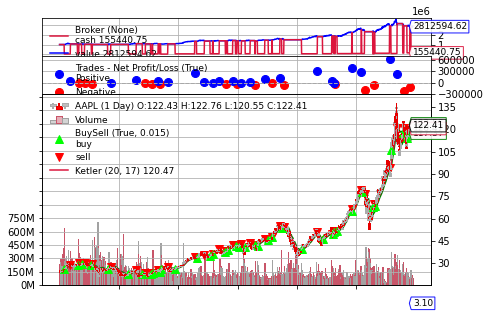

In [ ]:
cerebro.plot(style="candle")[0][0]

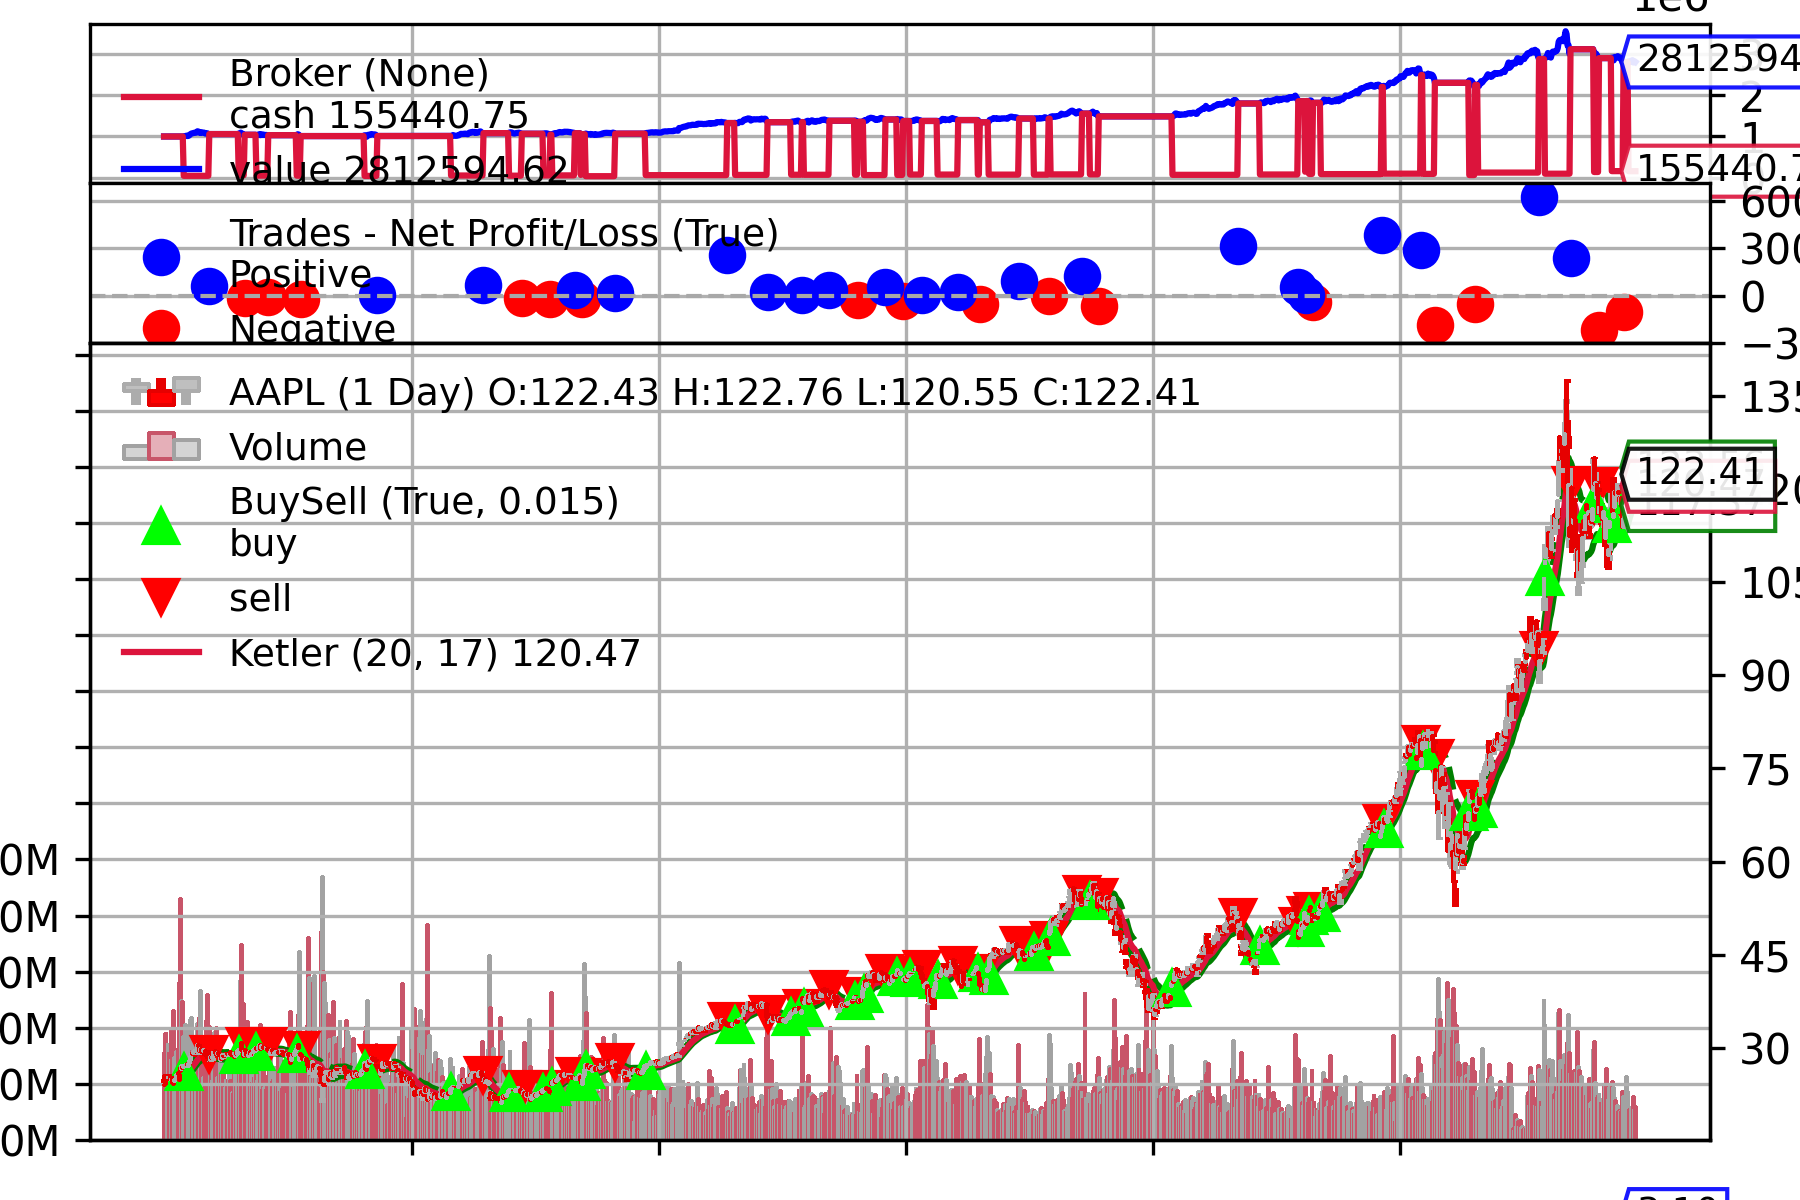

In [ ]:
from google.colab import files
from IPython.display import Image
chart_file = 'result.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read(), width=800)